In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from parso import split_lines
from torch.utils.data import random_split
%matplotlib inline

In [7]:
# read in words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [223]:
def build_dataset(words):
    block_size = 3
    X, Y = [] , []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [52]:
C = torch.randn((27, 2))

In [53]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([0.2296, 0.0498])

In [54]:
C[5]

tensor([0.2296, 0.0498])

In [55]:
C[X].shape

torch.Size([228146, 3, 2])

In [63]:
emb = C[X]
emb = torch.cat(torch.unbind(emb, 1), 1)
emb.shape

torch.Size([228146, 6])

In [64]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [65]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)

In [66]:
h.shape

torch.Size([228146, 100])

In [67]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [68]:
logits = h @ w2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [69]:
prob.shape

torch.Size([228146, 27])

In [224]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
w2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [225]:
sum(p.nelement() for p in parameters)

17697

In [226]:
for p in parameters:
    p.requires_grad = True

In [227]:
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre


In [228]:
#lri = []
lossi = []
stepi = []

In [232]:

for k in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
    logits = h @ w2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[k]
    if k < 10000:
        lr = 0.1
    elif k >= 10000 & k < 20000:
        lr = 0.05
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track lr
    # lri.append(lre[k]) # exponent of lr
    # lossi.append(loss.item())

    stepi.append(k)
    lossi.append(loss.log10().item())
print(loss.item())

2.215419054031372


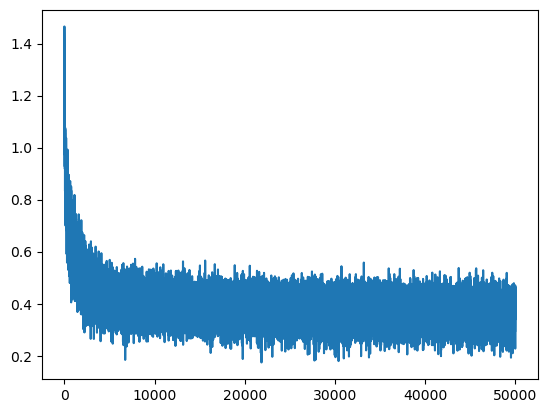

In [180]:
#plt.plot(lri, lossi)
#plt.plot(stepi, lossi)
plt.plot(stepi, lossi)

In [233]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3070, grad_fn=<NllLossBackward0>)

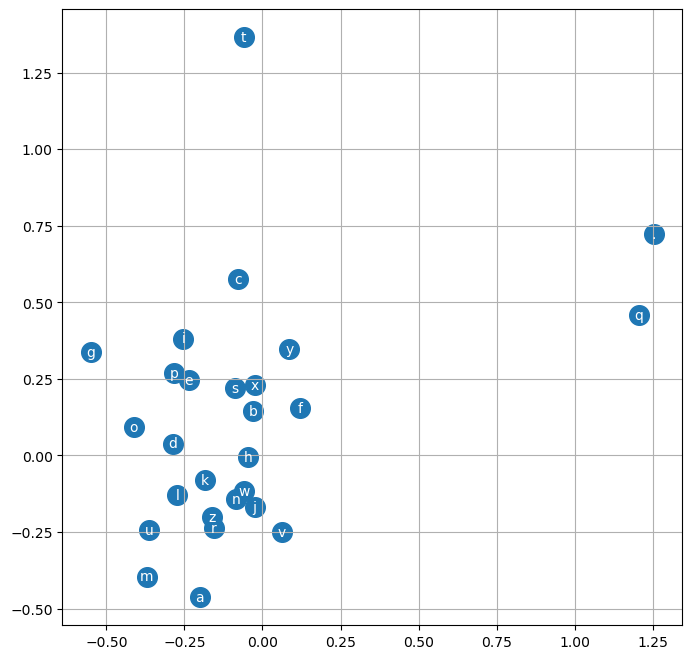

In [185]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("miner")

In [ ]:
# training, validation, testing

In [235]:
# sampling
block_size = 3
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
       # print(probs.shape)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''. join(itos[i] for i in out))

gafundley.
khantond.
milyne.
yuluwantiorah.
pymberrisari.
nah.
vamadeem.
wailebelondiel.
ayverenzlouristedon.
alie.
adalexx.
kasifyareem.
alyn.
emerise.
hhan.
vylilahestyn.
mea.
teckieland.
geymy.
ney.
